## Silhouette Methods

<br>

<div style="border: 1px solid #ccc; padding: 15px; background-color: #fdfdfd ; border-radius: 5px;">

### *Silhouette Score*

The Silhouette score evaluates clustering quality by comparing intra-cluster cohesion and inter-cluster separation (how similar each point $x_i$ is to its own cluster $C_j$ compared to other clusters $C_{d\ne j}$).  
Given a data point $x_i \in C_j$ , the silhouette score $s(x_i)$ is defined as:  

$$
s(x_i) = \frac{b(x_i) - a(x_i)}{\max{ \{a(x_i), \ b(x_i)} \} } \
$$

where $a(x_i)$ (**Intra-Cluster Distance**) measures the average distance between $x_i$ and other points in its own cluster $C_j$ and $b(x_i)$ (**Inter Cluster Distance**) is the minimum average distance to any other cluster $C_d$.

$$
a(x_i) = \frac{1}{|C_j|-1}  \sum_{x_k \in C_j, k \ne i}{d(x_i, x_k)} \ , \quad b(x_i) = \min_{d \ne j}\Bigl\{{\frac{1}{|C_d|} \sum_{x_k \in C_d}{d(x_i,x_k)}}\Bigr\}
$$


<div style="border: 1px solid #ccc; padding: 15px; background-color: #fdfdfd ; border-radius: 5px;">

### *Silhouette Aggregation*

To generalize silhouette analysis across an entire dataset ($n$ : number of data points, $ \ k$ : number of clusters) , we use two primary aggregation methods:  

* **Micro-average Silhouette score:** Averages silhouette scores across all individual points.
$$
S_\text{micro} = \frac{1}{n} \sum_{i=1}^{n}{s(x_i)}
$$
 Suitable when evaluating clustering consistency at the individual level, where each data point contributes equally to the final score.  
   
    <br>
    
* **Macro-average Silhouette score:** Averages the mean silhouette per cluster.
$$
S_\text{macro} = \frac{1}{k} \sum_{j=1}^{k}\frac{1}{|C_j|}\sum_{x_i \in C_j}{s(x_i)}
$$
 Suitable when ensuring equal importance to all clusters, regardless of size, preventing large clusters from dominating the score.
    
These aggregation methods provide complementary insights, with $S_\text{micro}$ emphasizing point-level clustering quality and $S_\text{macro}$ focusing on per-cluster clustering quality.

<div style="border: 1px solid #ccc; padding: 15px; background-color: #fdfdfd ; border-radius: 5px;">

### *Silhouette Approximation*

For large datasets, exact silhouette computation can be computationally expensive ~ $O(n^2$) . Instead, an approximation of silhouette (option: `approximation=True`) can be used in the following methods, based on the cluster centroids $(\mu_j)$ and the sum of squares within clusters $(SS_j = \sum_{x_i \in C_j}{\|x_i - \mu_j\|^2})$ to reduce the computational cost approximately to $O(n\cdot k)$.

* **Approximate Intra-Cluster Distance ($x_i \in C_j$):**
$$
\tilde a(x_i) = \sqrt{\frac{|C_j|\cdot \|x_i - \mu_j \|^2 + SS_j}{|C_j|-1}}
$$

<br>

* **Approximate Inter-Cluster Distance ($x_i \in C_j$):**
$$
\tilde b(x_i) = \min_{d\ne j}\Bigl\{\sqrt{\|x_i-\mu_d\|^2 + \frac{SS_d}{|C_d|}} \ \Bigr\}
$$

<br>

* **Approximate Silhouette score ($x_i \in C_j$):**
$$
\tilde s(x_i) = \frac{\tilde b(x_i) - \tilde a(x_i)}{\max{ \{\tilde a(x_i), \ \tilde b(x_i)} \} } \
$$    

Although we do not compute exact pairwise distances, this method tends to preserve the relative ranking/ordering of silhouette scores across different points and clusters. This is because the intra-cluster approximation captures point-to-centroid distances, weighted by the cluster's spread (sum of squares) and the inter-cluster approximation finds the closest centroid, adjusting for cluster compactness. As a result, while absolute values may slightly differ, the ordering of points based on silhouette scores remains reliably consistent. This makes it effective for:
*   **Choosing the optimal number of clusters (k)**.
*   **Comparing clustering solutions**.
*   **Identifying well-clustered vs. poorly-clustered points**.
  
  

<div style="border: 1px solid #ccc; padding: 15px; background-color: #fdfdfd ; border-radius: 5px;">

### *Appropriate Sampling Strategies*

To enhance computational efficiency while preserving accuracy, we apply different sampling methods based on the aggregation type:
*   **Uniform Sampling** for $S_\text{micro}$.  
Micro-averaging treats each point equally, meaning we need a sample that represents the overall dataset proportionally. Random selection across all points maintains the global distribution of silhouette scores without over-representing or under-representing any specific cluster. This ensures that the estimated $S_\text{micro}$ remains consistent with the full dataset.
  
    <br>
      
*   **Balanced (per cluster) Sampling** for $S_\text{macro}$.  
Macro-averaging gives equal weight to each cluster, so using standard random sampling could bias the result toward larger clusters. Instead, we sample approximately equal numbers of points from each cluster, ensuring that small clusters are fairly represented in the final macro-average calculation. This makes $S_\text{macro}$ robust to cluster size imbalances, maintaining its ability to evaluate overall clustering performance.

---

We present the following methods to compute and analyze silhouette scores, incorporating both exact and approximate computations, as well as micro- and macro-aggregations with appropriate sampling strategies:

*   **`point_silhouettes(X, labels, approximation=False, centers=None)`**

    Computes the **silhouette score for each point** in the dataset.     
    
      -  If `approximation=False`, uses **pairwise distances** for exact computation.    
      -  If `approximation=True`, applies the **centroid-based approximation** to reduce complexity.  
      
<br>

*   **`micro_silhouette(X, labels, approximation=False, centers=None, sample_size=-1, seed=42)`**    
    
      Computes the **micro-average silhouette score**.
      Uses **uniform sampling** when `sample_size` is specified.
  
<br>

*   **`macro_silhouette(X, labels, approximation=False, centers=None, sample_size=-1, seed=42)`**    
  
      Computes the **macro-average silhouette score**.
      Uses **balanced sampling** when `sample_size` is specified.

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_samples
from scipy.spatial.distance import cdist

def point_silhouettes(X, labels, approximation=False, centers=None):
    """
    Compute silhouette scores for each point in the dataset, with approximate computation option.

    Parameters:
       - X: array-like, shape (n_samples, n_features)
             The input data.
       - labels: array-like, shape (n_samples,)
                  The cluster labels for each sample.
       - approximation: bool, default=False
                        - If False, computes exact silhouette scores using sklearn's silhouette_samples.
                        - If True, uses an approximate silhouette computation based on centroids and sum of squares.
       - centers: pd.Series, default=None (optional: used only for approximation option)
                  A dictionary mapping cluster labels to their precomputed centroids.
                  - If provided/precomputed, these centroids are used for silhouette approximation.
                  - If None, centroids are computed as the mean of points in each cluster.

    Returns: np.ndarray, shape (n_samples,)
             The silhouette score for each point in X.
    """
    labels = np.asarray(labels)

    # Exact silhouette computation (approximation=False)
    if not approximation:
        return silhouette_samples(X, labels=labels)

    # Approximation (approximation=True)
    # Ensure each cluster has a centroid

    # Compute approximate centers (average of points) if centers not provided
    if centers is None:
        unique_labels = np.unique(labels)
        centers = pd.Series({cl: np.mean(X[labels == cl], axis=0) for cl in unique_labels})

    if hasattr(centers, 'index'):
        unique_labels = np.unique(labels)
        for cl in unique_labels:
            if cl not in centers.index:
                # If centroid not present, compute it as the mean of its cluster's points
                centers.at[cl] = np.mean(X[labels == cl], axis=0)
        centers = centers.sort_index()
        clusters = centers.index.to_numpy()
        mapping = {c: i for i, c in enumerate(clusters)}
        inv = np.array([mapping[label] for label in labels])
    else:
        # If centers a simple array-like, assume labels 0-based
        clusters = np.arange(len(centers))
        inv = labels

    k = len(clusters)
    n = X.shape[0]

    # Convert centers to a NumPy array
    centers_arr = np.array(centers.tolist())

    # Compute differences and squared distances between points and their assigned centroids
    diffs = X - centers_arr[inv]         # Shape: (n, d)
    dists_sq = np.sum(diffs**2, axis=1)    # Shape: (n,)

    # Compute per-cluster counts and within-cluster sum-of-squares (SS)
    counts = np.bincount(inv, minlength=k)
    SS_arr = np.bincount(inv, weights=dists_sq, minlength=k)

    # Compute full distance matrix from every point to every centroid
    D = cdist(X, centers_arr, metric='euclidean')

    # Extract for each point the distance to its own centroid
    D_diag = D[np.arange(n), inv]

    # For each point, get the count and SS corresponding to its cluster
    count_vec = counts[inv]
    ss_vec = SS_arr[inv]

    # Compute approximate intra-cluster distances a(x_i).
    a_vals = np.where(
        count_vec > 1,
        np.sqrt((count_vec * (D_diag ** 2) + ss_vec) / (count_vec - 1)),
        D_diag
    )

    # Compute candidate distances for b(x_i)
    # candidate_matrix[i, j] = sqrt( D[i, j]^2 + (SS_arr[j] / counts[j]) )
    cluster_term = SS_arr / np.maximum(counts, 1e-6)  # per-cluster term
    candidate_matrix = np.sqrt(D**2 + cluster_term.reshape(1, k))
    candidate_matrix[np.arange(n), inv] = np.inf  # Exclude own cluster

    # b(x_i) is the minimum candidate value
    b_vals = np.min(candidate_matrix, axis=1)

    # Maximum of a(x_i), b(x_i)
    max_ab = np.maximum(np.maximum(a_vals, b_vals), 1e-6) # Avoid zero division

    # Compute approximate silhouette scores for each point.
    silhouette_scores = (b_vals - a_vals) / max_ab

    return silhouette_scores

def micro_silhouette(X, labels, approximation=False, centers=None, sample_size=-1, seed=42):
    """
    Compute the micro-average silhouette score, the overall mean silhouette score across all points.

    Parameters:
       - X: array-like, shape (n_samples, n_features)
            The input dataset.
       - labels: array-like, shape (n_samples,)
                 Cluster labels for each sample.
       - approximation: bool, default=False
                        - If False, computes exact silhouette scores using sklearn's silhouette_samples.
                        - If True, uses an approximate silhouette computation based on centroids and sum of squares.
       - centers: dict or pd.Series, default=None (optional)
                  A dictionary mapping cluster labels to their precomputed centroids.
                  - If provided, these centroids are used for silhouette approximation.
                  - If None, centroids are computed as the mean of points in each cluster.
       - sample_size: int or float, default=-1
                      Number of points to sample uniformly (for micro-average silhouette score)
                      - If sample_size == -1: no sampling.
                      - If 0 <= sample_size <= 1: sample that fraction of the data.
                      - If sample_size > 1: sample that exact number of points.
       - seed: int, default=42
               Random seed for reproducibility, used when sampling is enabled (sample_size!=-1).

    Returns: float
             The micro-average silhouette score.
    """
    # If sampling is not enabled (sample_size=-1)
    if sample_size == -1:
        point_scores = point_silhouettes(X, labels, approximation=approximation, centers=centers)
    else: # If sampling is enabled (sample_size != -1)
        # Perform uniform sampling, as this sampling strategy aligns with micro-average silhouette score nature
        np.random.seed(seed)
        n_samples=len(X)
        labels = np.array(labels)
        if 0 <= sample_size <= 1: # sample_size as a fraction of the dataset
            size=int(np.ceil(sample_size*n_samples))
        elif sample_size > 1: # sample_size as the exact number of points to sample
            size=int(sample_size)
        else:
            raise ValueError(
                '"sample_size" must be -1, a fraction (between 0 and 1), or an exact number of data points'
            )
        if size == 0:
            raise ValueError("Sample size computed as 0. Increase sample_size or adjust the parameters.")

        indices=np.random.choice(n_samples, size=size, replace=False)

        num_sampled=len(indices)
        num_clusters=len(np.unique(labels[indices]))
        if num_sampled <= num_clusters:
            raise ValueError(
                  f"Uniform Sampling produced only {num_sampled} samples for {num_clusters} clusters. "
                  "Increase sample_size or adjust the sampling strategy.")

        # Silhouette scores computation on the sampled dataset
        point_scores = point_silhouettes(X[indices], labels[indices], approximation=approximation, centers=centers)

    return np.mean(point_scores)  # Simple mean across all points (micro)

def macro_silhouette(X, labels, approximation=False, centers=None, sample_size=-1, seed=42):
    """
    Compute the macro-average silhouette score, the mean of per-cluster silhouette scores.

    Parameters:
       - X: array-like, shape (n_samples, n_features)
            The input dataset.
       - labels: array-like, shape (n_samples,)
                 Cluster labels for each sample.
       - approximation: bool, default=False
                        - If False, computes exact silhouette scores using sklearn's silhouette_samples.
                        - If True, uses an approximate silhouette computation based on centroids and sum of squares.
       - centers: dict or pd.Series, default=None (optional)
                  A dictionary mapping cluster labels to their precomputed centroids.
                  - If provided, these centroids are used for silhouette approximation.
                  - If None, centroids are computed as the mean of points in each cluster.
       - sample_size: int or float, default=-1
                      Number of points to sample in a balanced way (for macro-average silhouette score)
                      - If sample_size == -1: no sampling.
                      - If 0 <= sample_size <= 1: sample that fraction of the data.
                      - If sample_size > 1: sample that exact number of points.
       - seed: int, default=42
               Random seed for reproducibility, used when sampling is enabled (sample_size!=-1).

    Returns:  float
              The macro-average silhouette score.
    """
    # sampling is not enabled (sample_size=-1)
    if sample_size == -1:
        point_scores = point_silhouettes(X, labels, approximation=approximation, centers=centers)
    else: # If sampling is enabled (sample_size != -1)
        # Perform balanced sampling, as this sampling strategy aligns with macro-average silhouette score nature
        np.random.seed(seed)
        n_samples=len(X)
        labels = np.array(labels)
        if 0 <= sample_size <= 1: # sample_size as a fraction of the dataset
            size=int(np.ceil(sample_size*n_samples))
        elif sample_size > 1: # sample_size as the exact number of points to sample
            size=int(sample_size)
        else:
            raise ValueError(
                '"sample_size" must be -1, a fraction (between 0 and 1), or an exact number of data points'
            )
        if size == 0:
            raise ValueError("Sample size computed as 0. Increase sample_size or adjust the parameters.")

        unique_clusters = np.unique(labels)
        samples_per_cluster = max(1, size // len(unique_clusters))
        indices_list = []
        for cluster_label in unique_clusters:
            cluster_indices = np.where(labels == cluster_label)[0]
            if len(cluster_indices) == 0:
                continue
            chosen_size = min(len(cluster_indices), samples_per_cluster)
            if chosen_size == 0:
                continue
            chosen_indices = np.random.choice(cluster_indices, size=chosen_size, replace=False)
            indices_list.append(chosen_indices)
        if indices_list:
            indices = np.concatenate(indices_list)
        else:
            indices = np.array([], dtype=int)
        if indices.shape[0] <= len(unique_clusters):
            raise ValueError(
                f"Balanced Sampling produced only {indices.shape[0]} samples for {len(unique_clusters)} clusters. "
                "Increase sample_size or adjust the sampling strategy.")

        # Retain the sampled dataset and labels array
        X = X[indices]
        labels = labels[indices]
        point_scores = point_silhouettes(X, labels, approximation=approximation, centers=centers)

    # Compute per-cluster mean silhouette scores
    unique_clusters = np.unique(labels)
    cluster_means = []

    for cluster in unique_clusters:
        cluster_scores = point_scores[labels == cluster]  # Get silhouette scores for the cluster
        cluster_means.append(cluster_scores.mean())  # Compute mean silhouette for this cluster

    return np.mean(cluster_means)  # Mean across all clusters (macro)



---





### Impact of Sampling and Approximation on Silhouette Computation (Example)

In [2]:
import time
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Synthetic data
X, _ = make_blobs(n_samples=100000, centers=5, random_state=42)

# Clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X)

# Cluster centers
centers = {i: kmeans.cluster_centers_[i] for i in range(5)}
centers = pd.Series(centers)

# Benchmarking
results = []
for sample_s in [-1, 0.7]:  # -1: no Sampling, 0.7: sampling (70% of the dataset)
    for approx in [False, True]:  # False: no approximation, True: approximation
        start = time.time()
        micro = micro_silhouette(X, labels, approximation=approx, centers=centers, sample_size=sample_s)
        macro = macro_silhouette(X, labels, approximation=approx, centers=centers, sample_size=sample_s)
        elapsed = time.time() - start

        approx_symbol = "Yes" if approx else "No"
        sample_symbol = "Yes" if sample_s != -1 else "No"

        results.append([sample_symbol, approx_symbol, micro, macro, elapsed])

df_results = pd.DataFrame(results, columns=["Sampling",
                                            "Approximation",
                                            "Micro-avg Silhouette",
                                            "Macro-avg Silhouette",
                                            "Time (s)"])
df_results.set_index(["Sampling", "Approximation"], inplace=True)
display(df_results)

Micro-avg Silhouette  Macro-avg Silhouette    Time (s)
Sampling Approximation                                                        
No       No                         0.667704              0.667693  122.264086
         Yes                        0.644024              0.644012    0.083234
Yes      No                         0.667539              0.668501   72.570498
         Yes                        0.643840              0.644726    0.062802



---



### Silhouette scores (with/without sampling , with/without approximation) across k (number of clusters)

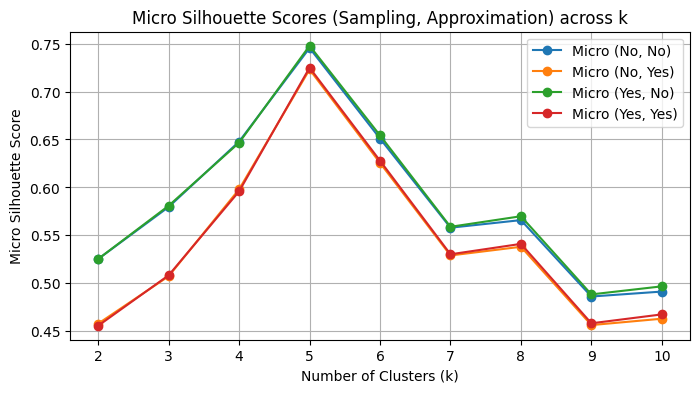

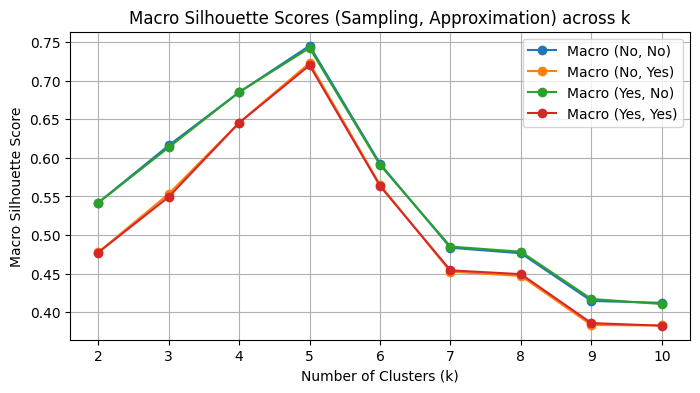

In [3]:
X, _ = make_blobs(n_samples=3000, centers=5, random_state=70)

k_values = range(2, 11)

results = []

# Loop over different k values
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = "auto")
    labels = kmeans.fit_predict(X)
    centers = {i: kmeans.cluster_centers_[i] for i in range(k)}
    centers = pd.Series(centers)

    for sample_s in [-1, 0.7]:
        for approx in [False, True]:
            start = time.time()
            micro = micro_silhouette(X, labels, approximation=approx, centers=centers, sample_size=sample_s)
            macro = macro_silhouette(X, labels, approximation=approx, centers=centers, sample_size=sample_s)
            elapsed = time.time() - start

            approx_symbol = "Yes" if approx else "No"
            sample_symbol = "Yes" if sample_s != -1 else "No"

            results.append([k, sample_symbol, approx_symbol, micro, macro, elapsed])

df_results = pd.DataFrame(results, columns=["k",
                                            "Sampling",
                                            "Approximation",
                                            "Micro-Silhouette",
                                            "Macro-Silhouette",
                                            "Time (s)"])

# Micro silhouette scores (with/without sampling , with/without approximation) across k (number of clusters)
plt.figure(figsize=(8, 4))
for (sample_symbol, approx_symbol), group in df_results.groupby(["Sampling", "Approximation"]):
    plt.plot(group["k"], group["Micro-Silhouette"], marker='o', label=f"Micro ({sample_symbol}, {approx_symbol})")

plt.xlabel("Number of Clusters (k)")
plt.ylabel("Micro Silhouette Score")
plt.title("Micro Silhouette Scores (Sampling, Approximation) across k")
plt.legend()
plt.grid(True)
plt.show()

# Macro silhouette scores (with/without sampling , with/without approximation) across k (number of clusters)
plt.figure(figsize=(8, 4))
for (sample_symbol, approx_symbol), group in df_results.groupby(["Sampling", "Approximation"]):
    plt.plot(group["k"], group["Macro-Silhouette"], marker='o', label=f"Macro ({sample_symbol}, {approx_symbol})")

plt.xlabel("Number of Clusters (k)")
plt.ylabel("Macro Silhouette Score")
plt.title("Macro Silhouette Scores (Sampling, Approximation) across k")
plt.legend()
plt.grid(True)
plt.show()



---



## Comparison of Silhouette Approximations

We compare two strategies for approximating silhouette scores that avoid the full, computationally expensive pairwise distance calculations:

1. **Refined Approximation**  

     This is the approximation we defined earlier in the notebook. It leverages the original silhouette formulas by estimating a combination of the point-to-centroid distance and a correction term based on the cluster’s within-cluster sum-of-squares.

2. **Simplified Approximation**  
  
     This common approximation computes the silhouette score using only the distances from each point to its assigned centroid and the minimum distance to any other cluster centroid, without any additional adjustments.


In [4]:
def approx_point_silhouettes(X, labels, centers=None):
    """
    Compute approximate silhouette scores for each point using
    centroids distances and within-cluster sum of squares.

    Parameters:
      - X: array-like, shape (n_samples, n_features)
           Input data.
      - labels: array-like, shape (n_samples,)
                Cluster labels for each sample.
      - centers: pd.Series or dict, optional
                 A mapping from cluster labels to centroids. If None, centroids
                 are computed as the mean of the points in each cluster.

    Returns:
      - np.ndarray of shape (n_samples,): Approximate silhouette scores.
    """
    labels = np.asarray(labels)

    # Compute centroids if not provided
    if centers is None:
        unique_labels = np.unique(labels)
        centers = pd.Series({cl: np.mean(X[labels == cl], axis=0) for cl in unique_labels})

    # Ensure all clusters have centroids
    if hasattr(centers, 'index'):
        unique_labels = np.unique(labels)
        for cl in unique_labels:
            if cl not in centers.index:
                centers.at[cl] = np.mean(X[labels == cl], axis=0)
        centers = centers.sort_index()
        clusters = centers.index.to_numpy()
        mapping = {c: i for i, c in enumerate(clusters)}
        inv = np.array([mapping[label] for label in labels])
    else:
        clusters = np.arange(len(centers))
        inv = labels

    k = len(clusters)
    n = X.shape[0]

    centers_arr = np.array(centers.tolist())

    # Compute squared distances from each point to its own centroid
    diffs = X - centers_arr[inv]
    dists_sq = np.sum(diffs**2, axis=1)

    # Compute per-cluster counts and sum-of-squares
    counts = np.bincount(inv, minlength=k)
    SS_arr = np.bincount(inv, weights=dists_sq, minlength=k)

    # Compute distance matrix from each point to every centroid
    D = cdist(X, centers_arr, metric='euclidean')
    D_diag = D[np.arange(n), inv]  # distances to the own centroids

    count_vec = counts[inv]
    ss_vec = SS_arr[inv]

    # Approximate intra-cluster distance (a(x))
    a_vals = np.where(
        count_vec > 1,
        np.sqrt((count_vec * (D_diag ** 2) + ss_vec) / (count_vec - 1)),
        D_diag
    )

    # For inter-cluster distances: for each point, combine the distance to a centroid
    # with the average within-cluster variance of that cluster
    cluster_term = SS_arr / np.maximum(counts, 1e-6)
    candidate_matrix = np.sqrt(D**2 + cluster_term.reshape(1, k))
    candidate_matrix[np.arange(n), inv] = np.inf  # exclude own cluster
    b_vals = np.min(candidate_matrix, axis=1)

    # Compute silhouette scores.
    max_ab = np.maximum(np.maximum(a_vals, b_vals), 1e-6)
    silhouette_scores = (b_vals - a_vals) / max_ab

    return silhouette_scores

def simplified_approx_point_silhouettes(X, labels, centers=None):
    """
    Compute a simplified approximate silhouette score for each point using only
    the distances to cluster centroids.

    For each point, this method uses:
      - a(x): the distance from the point to its own cluster centroid.
      - b(x): the minimum distance from the point to any other cluster centroid.

    Parameters:
      - X: array-like, shape (n_samples, n_features)
           Input data.
      - labels: array-like, shape (n_samples,)
                Cluster labels for each sample.
      - centers: pd.Series or dict, optional
                 A mapping from cluster labels to centroids. If None, centroids
                 are computed as the mean of the points in each cluster.

    Returns:
      - np.ndarray of shape (n_samples,): Simplified approximate silhouette scores.
    """
    labels = np.asarray(labels)

    # Compute centroids if not provided
    if centers is None:
        unique_labels = np.unique(labels)
        centers = pd.Series({cl: np.mean(X[labels == cl], axis=0) for cl in unique_labels})

    # Ensure all clusters have centroids
    if hasattr(centers, 'index'):
        unique_labels = np.unique(labels)
        for cl in unique_labels:
            if cl not in centers.index:
                centers.at[cl] = np.mean(X[labels == cl], axis=0)
        centers = centers.sort_index()
        clusters = centers.index.to_numpy()
        mapping = {c: i for i, c in enumerate(clusters)}
        inv = np.array([mapping[label] for label in labels])
    else:
        clusters = np.arange(len(centers))
        inv = labels

    centers_arr = np.array(centers.tolist())
    n = X.shape[0]

    # Compute the distance matrix from points to all centroids
    D = cdist(X, centers_arr, metric='euclidean')

    # a(x): distance to the assigned (own) centroid
    a_vals = D[np.arange(n), inv]

    # b(x): the smallest distance to any other centroid
    D_copy = D.copy()
    D_copy[np.arange(n), inv] = np.inf  # ignore own cluster
    b_vals = np.min(D_copy, axis=1)

    # Compute silhouette scores
    max_ab = np.maximum(np.maximum(a_vals, b_vals), 1e-6)
    silhouette_scores = (b_vals - a_vals) / max_ab

    return silhouette_scores

def micro_approx_silhouette(X, labels, centers=None, method='approx'):
    """
    Compute the micro-average silhouette score using approximate point silhouettes.
    """
    if method == 'approx':
        point_scores = approx_point_silhouettes(X, labels, centers=centers)
    elif method == 'simplified':
        point_scores = simplified_approx_point_silhouettes(X, labels, centers=centers)
    else:
        raise ValueError("Unknown method. Choose 'approx' or 'simplified'.")

    return np.mean(point_scores)

def macro_approx_silhouette(X, labels, centers=None, method='approx'):
    """
    Compute the macro-average silhouette score using approximate point silhouettes.
    """
    if method == 'approx':
        point_scores = approx_point_silhouettes(X, labels, centers=centers)
    elif method == 'simplified':
        point_scores = simplified_approx_point_silhouettes(X, labels, centers=centers)
    else:
        raise ValueError("Unknown method. Choose 'approx' or 'simplified'.")

    labels = np.asarray(labels)
    unique_labels = np.unique(labels)
    cluster_means = [np.mean(point_scores[labels == cl]) for cl in unique_labels]

    return np.mean(cluster_means)

We compare the **refined approximation** (our original approximation formulas) against the **simplified approximation** (a more straightforward, commonly used method) by evaluating both the micro-averaged (overall mean) and macro-averaged (cluster-level mean) silhouette scores. Additionally, we compute the error of each approximation relative to the exact silhouette scores (the “True Scores”) and record the execution time for each method.

- **Example**

In [5]:
X, _ = make_blobs(n_samples=100000, centers=5, random_state=42)
kmeans = KMeans(n_clusters=5, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X)

# Precomputed centers as pd.Series
centers = {i: kmeans.cluster_centers_[i] for i in range(5)}
centers = pd.Series(centers)

methods = {
    "True Scores": (
        lambda X, labels: micro_silhouette(X, labels, approximation=False, centers=centers, sample_size=-1),
        lambda X, labels: macro_silhouette(X, labels, approximation=False, centers=centers, sample_size=-1)
    ),
    "Refined Approximation": (
        lambda X, labels: micro_approx_silhouette(X, labels, centers=centers, method='approx'),
        lambda X, labels: macro_approx_silhouette(X, labels, centers=centers, method='approx')
    ),
    "Simplified Approximation": (
        lambda X, labels: micro_approx_silhouette(X, labels, centers=centers, method='simplified'),
        lambda X, labels: macro_approx_silhouette(X, labels, centers=centers, method='simplified')
    )
}

# Compute scores and execution times
results = []
for method_name, (micro_func, macro_func) in methods.items():
    start = time.time()
    micro_score = micro_func(X, labels)
    macro_score = macro_func(X, labels)
    elapsed = time.time() - start
    results.append([method_name, micro_score, macro_score, elapsed])

df_results = pd.DataFrame(results, columns=["Method",
                                            "Micro-avg Silhouette",
                                            "Macro-avg Silhouette",
                                            "Time (s)"])
df_results.set_index("Method", inplace=True)

# Compute errors relative to the True Scores
true_micro = df_results.loc["True Scores", "Micro-avg Silhouette"]
true_macro = df_results.loc["True Scores", "Macro-avg Silhouette"]

for method in df_results.index:
    if method != "True Scores":
        df_results.loc[method, "Micro Error"] = abs(df_results.loc[method, "Micro-avg Silhouette"] - true_micro)
        df_results.loc[method, "Macro Error"] = abs(df_results.loc[method, "Macro-avg Silhouette"] - true_macro)
    else:
        df_results.loc[method, "Micro Error"] = "---"
        df_results.loc[method, "Macro Error"] = "---"

df_results = df_results[["Micro-avg Silhouette", "Micro Error", "Macro-avg Silhouette", "Macro Error", "Time (s)"]]

display(df_results)

,Micro-avg Silhouette,Micro Error,Macro-avg Silhouette,Macro Error,Time (s)
Method,,,,,
True Scores,0.667704,---,0.667693,---,119.977448
Refined Approximation,0.644024,0.023681,0.644012,0.023681,0.066871
Simplified Approximation,0.754902,0.087198,0.754894,0.0872,0.055322


- **Evaluation on multiple synthetic and real-world datasets**

In [6]:
from sklearn.datasets import make_blobs, load_iris, load_wine, load_digits, fetch_openml, fetch_20newsgroups
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer

# Synthetic dataset 1 (Gaussian blobs with varied densities)
X_1, y_1 = make_blobs(n_samples=500, centers=5, cluster_std=[1.0, 2.5, 0.5, 1.5, 3.0], random_state=42)
k_1 = len(np.unique(y_1))

# Synthetic dataset 2 (High-dimensional blobs with regular std)
X_2, y_2 = make_blobs(n_samples=500, centers=5, n_features=12, cluster_std=1.0, random_state=42)
k_2 = len(np.unique(y_2))

# Synthetic dataset 3 (High-dimensional blobs with high std)
X_3, y_3 = make_blobs(n_samples=500, centers=5, n_features=12, cluster_std=2.5, random_state=42)
k_3 = len(np.unique(y_3))

# Synthetic dataset 4 (Non-convex: rings and lines with noise)
def generate_ring_and_line_with_noise(n_points=1000, noise_ratio=0.5, ring_radius=5, ring_thickness=0.5, line_length=10):
    np.random.seed(42)
    n_noise = int(n_points * noise_ratio)
    n_cluster = n_points - n_noise
    n_per_cluster = n_cluster // 2
    angles = np.random.uniform(0, 2*np.pi, n_per_cluster)
    radii = np.random.normal(ring_radius, ring_thickness, n_per_cluster)
    x_ring = radii * np.cos(angles)
    y_ring = radii * np.sin(angles)
    x_line = np.random.normal(0, 0.3, n_per_cluster)
    y_line = np.random.uniform(-line_length/2, line_length/2, n_per_cluster)
    box_size = ring_radius * 3
    noise_x = np.random.uniform(-box_size, box_size, n_noise)
    noise_y = np.random.uniform(-box_size, box_size, n_noise)
    X = np.vstack([
        np.column_stack([x_ring, y_ring]),
        np.column_stack([x_line, y_line]),
        np.column_stack([noise_x, noise_y])
    ])
    y_ring_labels = np.zeros(n_per_cluster, dtype=int)
    y_line_labels = np.ones(n_per_cluster, dtype=int)
    y_noise_labels = np.full(n_noise, 2, dtype=int)
    y_true = np.concatenate([y_ring_labels, y_line_labels, y_noise_labels])
    return X, y_true

X_4, y_4 = generate_ring_and_line_with_noise(n_points=1500, noise_ratio=0.5, ring_radius=5, ring_thickness=0.5, line_length=10)
k_4 = len(np.unique(y_4))

# Iris dataset
data_iris = load_iris()
X_iris = data_iris.data
y_iris = data_iris.target
scaler = StandardScaler()
X_iris = scaler.fit_transform(X_iris)
k_iris = len(np.unique(y_iris))

# Mice Protein dataset
data_mice = fetch_openml(name='MiceProtein', version=4, parser='auto')
X_mice = data_mice.data
y_mice = data_mice.target
imputer = SimpleImputer(strategy='mean')
X_mice_imputed = imputer.fit_transform(X_mice)
scaler = StandardScaler()
X_mice = scaler.fit_transform(X_mice_imputed)
k_mice = len(np.unique(y_mice))

# Glass dataset
data_glass = fetch_openml(name='glass', version=1, parser='auto')
X_glass = data_glass.data
y_glass = data_glass.target
scaler = StandardScaler()
X_glass = scaler.fit_transform(X_glass)
k_glass = len(np.unique(y_glass))

# Wine dataset
data_wine = load_wine()
X_wine = data_wine.data
y_wine = data_wine.target
pca = PCA(n_components=0.95)
X_wine = pca.fit_transform(X_wine)
k_wine = len(np.unique(y_wine))

# Digits dataset
data_digits = load_digits()
X_digits = data_digits.data
y_digits = data_digits.target
pca = PCA(n_components=0.95)
X_digits = pca.fit_transform(X_digits)
k_digits = len(np.unique(y_digits))

# 20 Newsgroups subset: baseball, hockey, autos, motorcycles
categories_o = ['rec.sport.baseball', 'rec.sport.hockey', 'rec.autos', 'rec.motorcycles']
newsgroups_o = fetch_20newsgroups(categories=categories_o, remove=('headers', 'footers', 'quotes'))
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
X_data_txt_o = newsgroups_o.data
y_newsgroups = newsgroups_o.target
X_tfidf_o = vectorizer.fit_transform(X_data_txt_o)
X_tfidf_o = X_tfidf_o.toarray()
X_tfidf_o = PCA(0.90).fit_transform(X_tfidf_o)
X_newsgroups = X_tfidf_o
k_newsgroups = len(np.unique(y_newsgroups))

# Combine datasets into a dictionary
datasets = {
    "Synthetic 1": (X_1, k_1),
    "Synthetic 2": (X_2, k_2),
    "Synthetic 3": (X_3, k_3),
    "Synthetic 4": (X_4, k_4),
    "Iris": (X_iris, k_iris),
    "Mice Protein": (X_mice, k_mice),
    "Glass": (X_glass, k_glass),
    "Wine": (X_wine, k_wine),
    "Digits": (X_digits, k_digits),
    "20 Newsgroups": (X_newsgroups, k_newsgroups)
}

def compare_silhouette_methods(X, labels, n_clusters=None, centers=None):
    """
    Compare the silhouette score methods
    (True, Refined Approximation, Simplified Approximation)
    for the given dataset.
    """

    if n_clusters is None:
        n_clusters = len(np.unique(labels))

    if centers is None:
       centers = {i: np.mean(X[labels == i], axis=0) for i in range(n_clusters)}
       centers = pd.Series(centers)

    methods = {
        "True Scores": (
            lambda X, labels: micro_silhouette(X, labels, approximation=False, centers=centers, sample_size=-1),
            lambda X, labels: macro_silhouette(X, labels, approximation=False, centers=centers, sample_size=-1)
        ),
        "Refined Approximation": (
            lambda X, labels: micro_approx_silhouette(X, labels, centers=centers, method='approx'),
            lambda X, labels: macro_approx_silhouette(X, labels, centers=centers, method='approx')
        ),
        "Simplified Approximation": (
            lambda X, labels: micro_approx_silhouette(X, labels, centers=centers, method='simplified'),
            lambda X, labels: macro_approx_silhouette(X, labels, centers=centers, method='simplified')
        )
    }

    results = []
    for method_name, (micro_func, macro_func) in methods.items():
        start = time.time()
        micro_score = micro_func(X, labels)
        macro_score = macro_func(X, labels)
        elapsed = time.time() - start
        results.append([method_name, micro_score, macro_score, elapsed])

    df_results = pd.DataFrame(results, columns=["Method",
                                                "Micro-avg Silhouette",
                                                "Macro-avg Silhouette",
                                                "Time (s)"])
    df_results.set_index("Method", inplace=True)

    true_micro = df_results.loc["True Scores", "Micro-avg Silhouette"]
    true_macro = df_results.loc["True Scores", "Macro-avg Silhouette"]

    for method in df_results.index:
        if method != "True Scores":
            df_results.loc[method, "Micro Error"] = abs(df_results.loc[method, "Micro-avg Silhouette"] - true_micro)
            df_results.loc[method, "Macro Error"] = abs(df_results.loc[method, "Macro-avg Silhouette"] - true_macro)
        else:
            df_results.loc[method, "Micro Error"] = "-"
            df_results.loc[method, "Macro Error"] = "-"

    df_results = df_results[["Micro-avg Silhouette", "Micro Error", "Macro-avg Silhouette", "Macro Error", "Time (s)"]]
    return df_results

for ds_name, (X, k) in datasets.items():
    print(f"\n\n\nDataset: {ds_name}")
    # Clustering using KMeans (with number of clusters equal to ground-truth k)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X)
    centers = pd.Series({i: kmeans.cluster_centers_[i] for i in range(k)})
    df_results = compare_silhouette_methods(X, labels, k, centers)
    display(df_results)




Dataset: Synthetic 1


,Micro-avg Silhouette,Micro Error,Macro-avg Silhouette,Macro Error,Time (s)
Method,,,,,
True Scores,0.576659,-,0.565267,-,0.013061
Refined Approximation,0.543209,0.033451,0.532448,0.03282,0.001160
Simplified Approximation,0.680838,0.104178,0.671580,0.106312,0.000782





Dataset: Synthetic 2


,Micro-avg Silhouette,Micro Error,Macro-avg Silhouette,Macro Error,Time (s)
Method,,,,,
True Scores,0.813602,-,0.813602,-,0.016813
Refined Approximation,0.810820,0.002782,0.810820,0.002782,0.001281
Simplified Approximation,0.867733,0.05413,0.867733,0.05413,0.000836





Dataset: Synthetic 3


,Micro-avg Silhouette,Micro Error,Macro-avg Silhouette,Macro Error,Time (s)
Method,,,,,
True Scores,0.405901,-,0.349454,-,0.020168
Refined Approximation,0.386496,0.019405,0.338439,0.011015,0.001320
Simplified Approximation,0.514087,0.108186,0.444534,0.09508,0.000873





Dataset: Synthetic 4


,Micro-avg Silhouette,Micro Error,Macro-avg Silhouette,Macro Error,Time (s)
Method,,,,,
True Scores,0.306225,-,0.308479,-,0.048642
Refined Approximation,0.264447,0.041778,0.271833,0.036645,0.002083
Simplified Approximation,0.456863,0.150638,0.456385,0.147906,0.001480





Dataset: Iris


,Micro-avg Silhouette,Micro Error,Macro-avg Silhouette,Macro Error,Time (s)
Method,,,,,
True Scores,0.479881,-,0.443687,-,0.008769
Refined Approximation,0.440391,0.039491,0.394748,0.048939,0.000707
Simplified Approximation,0.611143,0.131261,0.582625,0.138937,0.000435





Dataset: Mice Protein


,Micro-avg Silhouette,Micro Error,Macro-avg Silhouette,Macro Error,Time (s)
Method,,,,,
True Scores,0.133880,-,0.166364,-,0.040402
Refined Approximation,0.126506,0.007374,0.156056,0.010308,0.003356
Simplified Approximation,0.231295,0.097415,0.272329,0.105965,0.002239





Dataset: Glass


,Micro-avg Silhouette,Micro Error,Macro-avg Silhouette,Macro Error,Time (s)
Method,,,,,
True Scores,0.330722,-,0.378135,-,0.003864
Refined Approximation,0.287842,0.042881,0.336470,0.041665,0.001002
Simplified Approximation,0.494865,0.164143,0.541573,0.163438,0.000571





Dataset: Wine


,Micro-avg Silhouette,Micro Error,Macro-avg Silhouette,Macro Error,Time (s)
Method,,,,,
True Scores,0.568989,-,0.552825,-,0.002474
Refined Approximation,0.523291,0.045698,0.501935,0.05089,0.000637
Simplified Approximation,0.670858,0.101869,0.661512,0.108687,0.000357





Dataset: Digits


,Micro-avg Silhouette,Micro Error,Macro-avg Silhouette,Macro Error,Time (s)
Method,,,,,
True Scores,0.194752,-,0.198736,-,0.069998
Refined Approximation,0.182806,0.011946,0.186469,0.012267,0.003567
Simplified Approximation,0.296021,0.10127,0.301060,0.102324,0.002570





Dataset: 20 Newsgroups


,Micro-avg Silhouette,Micro Error,Macro-avg Silhouette,Macro Error,Time (s)
Method,,,,,
True Scores,0.066957,-,0.086754,-,0.138833
Refined Approximation,0.054602,0.012355,0.082536,0.004217,0.004203
Simplified Approximation,0.128740,0.061783,0.142811,0.056057,0.002797


The refined approximation consistently produced silhouette scores that closely match the true scores while significantly reducing computation time. In contrast, although the simplified approximation is marginally faster, it tends to introduce larger errors compared to the true values. Overall, the refined method offers a better balance of accuracy and efficiency.

---

### Spearman Rank Correlation Analysis

We compute the Spearman rank correlations between the exact silhouette scores and the approximated scores for each dataset. This analysis verifies whether the approximations preserve the relative ordering of data points compared to the exact scores.

In [7]:
from scipy.stats import spearmanr

results_corr = []

def format_p(p):
    return "-" if p > 0.05 else "+"

for ds_name, (X, k) in datasets.items():
    # Clustering using KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X)

    centers = pd.Series({i: kmeans.cluster_centers_[i] for i in range(k)})

    true_scores = silhouette_samples(X, labels)

    # Compute refined approximate silhouette scores
    refined_scores = approx_point_silhouettes(X, labels, centers=centers)

    # Compute simplified approximate silhouette scores
    simplified_scores = simplified_approx_point_silhouettes(X, labels, centers=centers)

    # Compute Spearman correlation coefficients
    corr_refined, p_refined = spearmanr(true_scores, refined_scores)
    corr_simplified, p_simplified = spearmanr(true_scores, simplified_scores)

    results_corr.append([ds_name, round(corr_refined, 3), format_p(p_refined), round(corr_simplified, 3), format_p(p_simplified)])

df_corr = pd.DataFrame(results_corr, columns=["Dataset",
                                              "Refined Corr",
                                              "St. Significance (5%)",
                                              "Simplified Corr",
                                              "St.Significance (5%)"]).set_index("Dataset")


results_values = df_corr[["Refined Corr", "Simplified Corr"]].rename(
    columns={"Refined Corr": "Refined Approximation Correlation",
             "Simplified Corr": "Simplified Approximation Correlation"}
)

print("\nStatistically Significant (p < 0.05) Correlations with Exact Silhouette Scores:\n")

display(results_values)


Statistically Significant (p < 0.05) Correlations with Exact Silhouette Scores:



,Refined Approximation Correlation,Simplified Approximation Correlation
Dataset,,
Synthetic 1,0.994,0.958
Synthetic 2,1.000,0.935
Synthetic 3,0.999,0.985
Synthetic 4,0.965,0.919
Iris,0.984,0.906
Mice Protein,0.997,0.846
Glass,0.988,0.917
Wine,0.984,0.915
Digits,0.998,0.961


Both approximation methods have a strong monotonic relationship with the exact silhouette scores, but the refined approximation consistently exhibits nearly perfect correlation (often above 0.98) across all datasets, whereas the simplified approximation, though still high, tends to be lower (in some cases below 0.90, e.g. 20 Newsgroups and Mice Protein).

### Conclusion
- The **Refined Approximation** reliably preserves the ranking of the exact silhouette scores with correlations very close to 1, making it a robust alternative to the exact score computation.
-The **Simplified Approximation** sometimes deviates more, especially on datasets with more heterogeneous clusters.